<a href="https://colab.research.google.com/github/raplima/2020_cores_object_detection/blob/master/pyscripts/detectron2_cores.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Detectron2 for object detection with core images

This project is built using [detectron2](https://github.com/facebookresearch/detectron2).  
Here, we will :
* Train a detectron2 model on a dataset of interpreted core images
* Compute the performance statistics
* Run inference on images with the newly trained detectron2 model

You can see a more complete example of detectron2 usage in their [notebook](https://colab.research.google.com/drive/16jcaJoc6bCFAQ96jDe2HwtXj7BMD_-m5).


# Install detectron2
As shown [here](https://colab.research.google.com/drive/16jcaJoc6bCFAQ96jDe2HwtXj7BMD_-m5).

In [1]:
# install dependencies: (use cu101 because colab has CUDA 10.1)
!pip install -U torch==1.5 torchvision==0.6 -f https://download.pytorch.org/whl/cu101/torch_stable.html 
!pip install cython pyyaml==5.1
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version
# opencv is pre-installed on colab
# install detectron2:
!pip install detectron2==0.1.2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/index.html

Looking in links: https://download.pytorch.org/whl/cu101/torch_stable.html
Requirement already up-to-date: torch==1.5 in /usr/local/lib/python3.6/dist-packages (1.5.0+cu101)
Requirement already up-to-date: torchvision==0.6 in /usr/local/lib/python3.6/dist-packages (0.6.0+cu101)
     |████████████████████████████████| 276kB 3.5MB/s 
  Created wheel for pyyaml: filename=PyYAML-5.1-cp36-cp36m-linux_x86_64.whl size=44074 sha256=41870054cd4d82b992d592eb2e4fb96793b172ff454ea7a9e67bb81bfd1a670d
  Stored in directory: /root/.cache/pip/wheels/ad/56/bc/1522f864feb2a358ea6f1a92b4798d69ac783a28e80567a18b
Successfully built pyyaml
  Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-ic06i0wt
  Running command git clone -q https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-ic06i0wt
  Created wheel for pycocotools: filename=pycocotools-2.0-cp36-cp36m-lin

In [0]:
# You may need to restart your runtime prior to this, to let your installation take effect
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import cv2
import random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog

# import the remaining of the necessary modules
import os
import json

from detectron2.structures import BoxMode
# to train
from detectron2.engine import DefaultTrainer
# to evaluate
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

# Train on a custom dataset

In this section, we will train an existing detectron2 model on a custom dataset in a new format.

We use the dataset with interpreted lithofacies.
We'll train a new segmentation model from an existing model pre-trained on COCO dataset, available in detectron2's model zoo.

Note that COCO dataset does not have the "new" category. We'll be able to recognize this new class in a few minutes.

## Prepare the dataset

In [0]:
# download, decompress the data
#!wget --no-check-certificate -r 'https://sooners-my.sharepoint.com/:u:/g/personal/rlima_ou_edu/EYV0o7UIPzRNrhGFr_WMhSFlQ?e=YQtIaJ' -O Van_Horn_Well.zip
!unzip Van_Horn_Well.zip > /dev/null

Register the dataset to detectron2, following the [detectron2 custom dataset tutorial](https://detectron2.readthedocs.io/tutorials/datasets.html).
Here, the dataset is in its custom format, therefore we write a function to parse it and prepare it into detectron2's standard format. See the tutorial for more details.


In [0]:
# if your dataset is in COCO format, this cell can be replaced by the following three lines:
# from detectron2.data.datasets import register_coco_instances
# register_coco_instances("my_dataset_train", {}, "json_annotation_train.json", "path/to/image/dir")
# register_coco_instances("my_dataset_val", {}, "json_annotation_val.json", "path/to/image/dir")

def get_data_dicts(img_dir):
    # get the classes:
    with open(os.path.join(img_dir, "classes.txt"), 'r') as f:
        classes = f.read()
    # transform to list:
    classes = classes.split(sep='\n')

    json_file = os.path.join(img_dir, "via_region_data.json")
    with open(json_file) as f:
        imgs_anns = json.load(f)

    dataset_dicts = []
    for idx, v in enumerate(imgs_anns.values()):
        record = {}
        
        filename = os.path.join(img_dir, v["filename"])
        height, width = cv2.imread(filename).shape[:2]
        
        record["file_name"] = filename
        record["image_id"] = idx
        record["height"] = height
        record["width"] = width
      
        annos = v["regions"]
        objs = []
        for _, anno in annos.items():
            #assert not anno["region_attributes"]
            region = anno['region_attributes']
            anno = anno["shape_attributes"]
            px = anno["all_points_x"]
            py = anno["all_points_y"]
            poly = [(x + 0.5, y + 0.5) for x, y in zip(px, py)]
            poly = [p for x in poly for p in x]

            obj = {
                "bbox": [np.min(px), np.min(py), np.max(px), np.max(py)],
                "bbox_mode": BoxMode.XYXY_ABS,
                "segmentation": [poly],
                "category_id": classes.index(region['label']),
                "iscrowd": 0
            }
            objs.append(obj)
        record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts

In [5]:
path_train = 'Van_Horn_Well'
path_val = 'Van_Horn_Well'
# get the classes:
with open(os.path.join(path_train, "classes.txt"), 'r') as f:
    classes = f.read()
# transform to list:
classes = classes.split(sep='\n')
# thing_colors (list[tuple(r, g, b)]): Pre-defined color (in [0, 255]) for each thing category
colors_dict = {
    'Skeletal wackestone packstone': (255, 255, 102),
    'Chert-cherty breccia': (153, 153, 102),
    'Structureless siltstone sandstone': (102, 153, 153),
    'Cross-laminated siltstone': (51, 102, 255),
    'Laminated siltstone': (179, 198, 255),
    'Bioturbated siltstone': (71, 71, 107),
    'Glauconitic siltstone-sandstone': (255, 102, 255),
}
classes_colors = [colors_dict[lit] for lit in classes]

from detectron2.data import DatasetCatalog, MetadataCatalog

for d in ["train", "val"]:
  DatasetCatalog.register("Van_Horn_Well_" + d, lambda d=d: get_data_dicts("Van_Horn_Well"))
  MetadataCatalog.get("Van_Horn_Well_" + d).set(thing_classes=classes)
  MetadataCatalog.get("Van_Horn_Well_" + d).set(thing_colors=classes_colors)

train_metadata = MetadataCatalog.get(f"{path_train}_train")
val_metadata = MetadataCatalog.get(f"{path_train}_val")
print('ok')

ok


To verify the data loading is correct, let's visualize the annotations of randomly selected samples in the training set:



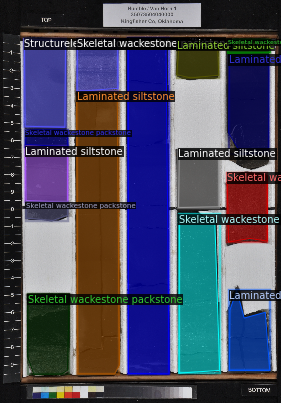

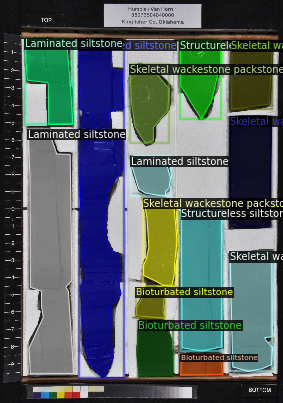

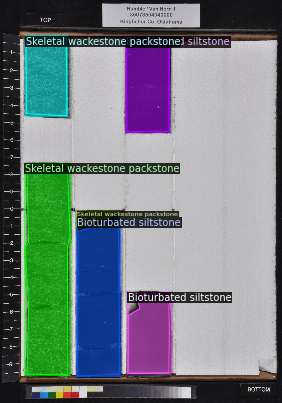

In [6]:
dataset_dicts = get_data_dicts(path_train)
for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=train_metadata, scale=0.1)
    vis = visualizer.draw_dataset_dict(d)
    cv2_imshow(vis.get_image()[:, :, ::-1])

## Train!

Now, let's fine-tune a coco-pretrained R50-FPN Mask R-CNN model on the balloon dataset. It takes ~22 minutes to train 1000 iterations on Colab's K80 GPU, or ~20 minutes on a P100 GPU.


In [15]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = (f"{path_train}_train",)
cfg.DATASETS.TEST = (f"{path_train}_val",)
cfg.DATALOADER.NUM_WORKERS = 2
# Let training initialize from model zoo
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  

cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 1000    

cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = len(classes)   # number of classes

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)

# print GPU information
!nvidia-smi

[05/19 13:35:01 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

'roi_heads.box_predictor.cls_score.weight' has shape (81, 1024) in the checkpoint but (8, 1024) in the model! Skipped.
'roi_heads.box_predictor.cls_score.bias' has shape (81,) in the checkpoint but (8,) in the model! Skipped.
'roi_heads.box_predictor.bbox_pred.weight' has shape (320, 1024) in the checkpoint but (28, 1024) in the model! Skipped.
'roi_heads.box_predictor.bbox_pred.bias' has shape (320,) in the checkpoint but (28,) in the model! Skipped.
'roi_heads.mask_head.predictor.weight' has shape (80, 256, 1, 1) in the checkpoint but (7, 256, 1, 1) in the model! Skipped.
'roi_heads.mask_head.predictor.bias' has shape (80,) in the checkpoint but (7,) in the model! Skipped.


Tue May 19 13:35:07 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   61C    P0    60W / 149W |   7639MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
trainer.train()

[05/19 13:35:14 d2.engine.train_loop]: Starting training from iteration 0
[05/19 13:35:42 d2.utils.events]:  eta: 0:22:23  iter: 19  total_loss: 4.497  loss_cls: 2.280  loss_box_reg: 0.876  loss_mask: 0.694  loss_rpn_cls: 0.434  loss_rpn_loc: 0.238  time: 1.3426  data_time: 0.4695  lr: 0.000005  max_mem: 5001M


In [9]:
# Look at training curves in tensorboard:
%load_ext tensorboard
%tensorboard --logdir output
# images can be exported as SVG for further edits before publication

<IPython.core.display.Javascript object>

## Inference & evaluation using the trained model
Now, let's run inference with the trained model on the balloon validation dataset. First, let's create a predictor using the model we just trained:



In [0]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set the testing threshold for this model
cfg.DATASETS.TEST = (f"{path_val}_val", )
predictor = DefaultPredictor(cfg)

Then, we randomly select several samples to visualize the prediction results.

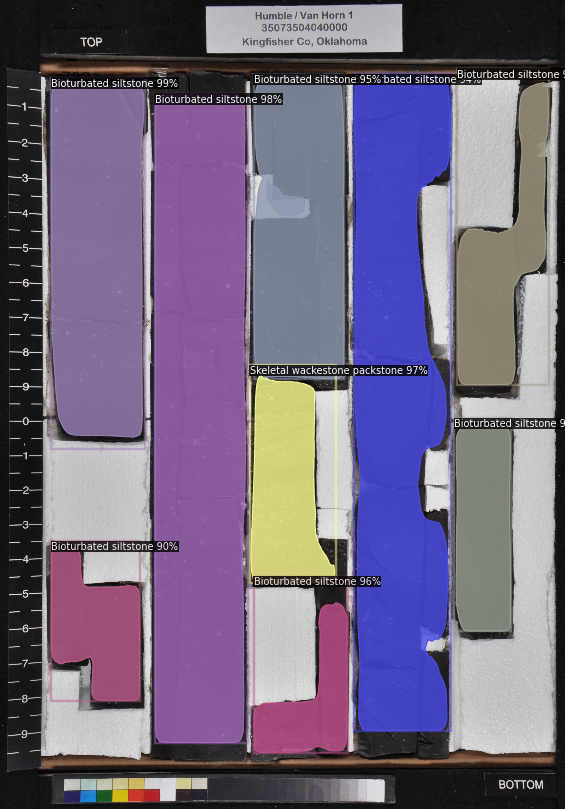

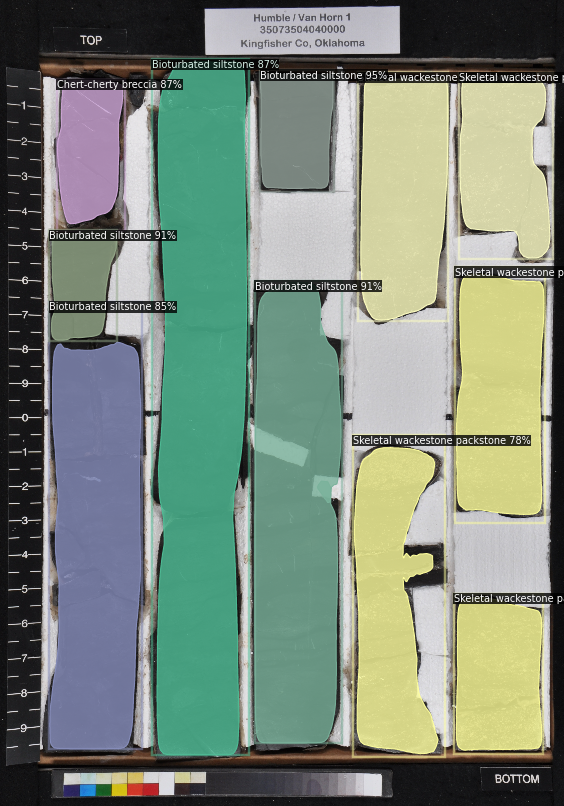

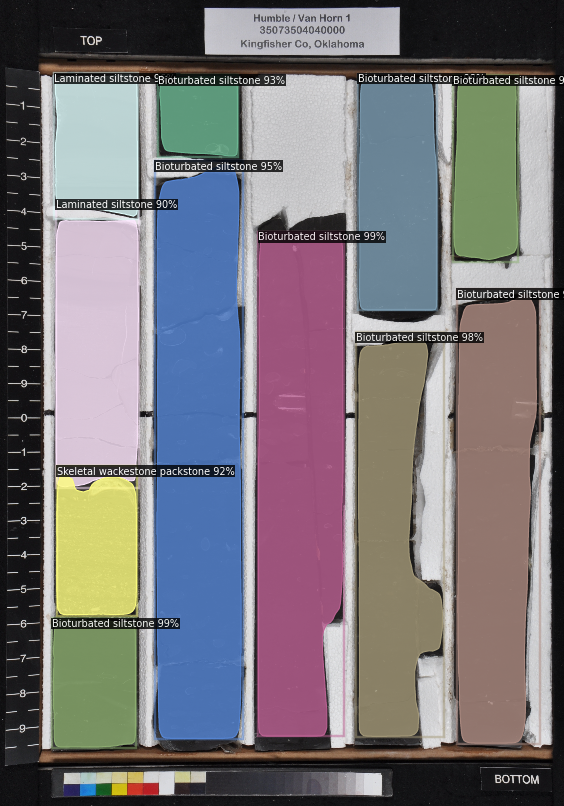

In [11]:
from detectron2.utils.visualizer import ColorMode
dataset_dicts = get_data_dicts(path_val)
for d in random.sample(dataset_dicts, 3):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=val_metadata, 
                   scale=0.2, 
                   instance_mode=ColorMode.SEGMENTATION   # remove the colors of unsegmented pixels
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(v.get_image()[:, :, ::-1])
    cv2.imwrite(f'{d["file_name"]}_predicted.png', v.get_image()[:, :, ::-1])

We can also evaluate its performance using AP metric implemented in COCO API.
This gives an AP of ~70%. Not bad!

In [12]:
evaluator = COCOEvaluator(f"{path_val}_val", cfg, False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, f"{path_val}_val")
inference_on_dataset(trainer.model, val_loader, evaluator)
# another equivalent way is to use trainer.test

WARNING [05/19 13:26:57 d2.evaluation.coco_evaluation]: json_file was not found in MetaDataCatalog for 'Van_Horn_Well_val'. Trying to convert it to COCO format ...
[05/19 13:26:57 d2.data.datasets.coco]: Converting annotations of dataset 'Van_Horn_Well_val' to COCO format ...)
[05/19 13:27:03 d2.data.datasets.coco]: Converting dataset dicts into COCO format
[05/19 13:27:03 d2.data.datasets.coco]: Conversion finished, num images: 18, num annotations: 189
[05/19 13:27:03 d2.data.datasets.coco]: Caching COCO format annotations at './output/Van_Horn_Well_val_coco_format.json' ...
[05/19 13:27:09 d2.data.common]: Serializing 18 elements to byte tensors and concatenating them all ...
[05/19 13:27:09 d2.data.common]: Serialized dataset takes 0.06 MiB
[05/19 13:27:09 d2.evaluation.evaluator]: Start inference on 18 images
[05/19 13:28:15 d2.evaluation.evaluator]: Inference done 11/18. 0.6591 s / img. ETA=0:00:36
[05/19 13:28:21 d2.evaluation.evaluator]: Inference done 12/18. 0.6492 s / img. ETA

OrderedDict([('bbox',
              {'AP': 68.63680101057854,
               'AP-Bioturbated siltstone': 83.56622052181257,
               'AP-Chert-cherty breccia': 84.09035693485315,
               'AP-Cross-laminated siltstone': 10.099009900990099,
               'AP-Glauconitic siltstone-sandstone': nan,
               'AP-Laminated siltstone': 73.43970389520156,
               'AP-Skeletal wackestone packstone': 79.40851811094393,
               'AP-Structureless siltstone sandstone': 81.21699669966998,
               'AP50': 83.29525925172318,
               'AP75': 81.52128362390677,
               'APl': 68.63680101057854,
               'APm': nan,
               'APs': nan}),
             ('segm',
              {'AP': 69.17970656651251,
               'AP-Bioturbated siltstone': 84.8081437976947,
               'AP-Chert-cherty breccia': 85.91640159491062,
               'AP-Cross-laminated siltstone': 13.465346534653467,
               'AP-Glauconitic siltstone-sandstone': n

In [13]:
  # donwload images with results
from google.colab import files
res = os.listdir(path_val)
for r in res:
  if 'predicted' in r:
    print(r)
    files.download(os.path.join(path_val, r))

Box 17 Depths 7885-7895.JPG_predicted.png
Box 6 Depths 7775-7785.JPG_predicted.png
Box 12 Depths 7835-7845.JPG_predicted.png


In [0]:
# delete folders
!rm -r output
!rm -r Van_Horn_Well